# Test with Autoencoders

The idea is to use an autoencoder to learn a compressed representation of the data with the different features. Such a trained model should be able to understand hidden correlation between features under targeted noise.

In [19]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('processed_features_num_cat.csv').set_index('SpeciesName').drop('SpeciesName.1', axis=1).drop('Genus', axis=1)

na_threshold = 0.7

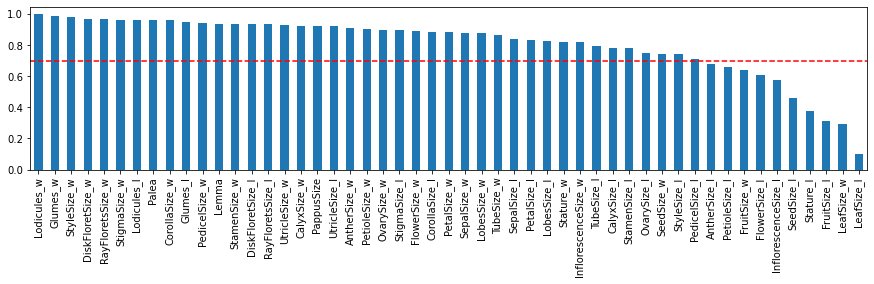

In [20]:
tmp = dataset.isna().sum().sort_values(ascending=False)/dataset.shape[0]

g = tmp[tmp > 0].plot.bar(figsize=(15, 3))
g.axhline(na_threshold, color='red', linestyle='--')

In [21]:
# remove the columns with nan ratio > 0.5
cols_to_drop = dataset.isna().sum()[dataset.isna().sum() > na_threshold*dataset.shape[0]].index
dataset = dataset.drop(columns=cols_to_drop)

### Warm-up: classical imputation

In [22]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split the dataset into train and test
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

perturbed_test = test.copy()

# impute the missing values with mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(train)
train_sim = pd.DataFrame(imputer.transform(train), columns=train.columns, index=train.index)
test_sim = pd.DataFrame(imputer.transform(test), columns=test.columns, index=test.index)

# impute the missing values with knn
imputer = KNNImputer(n_neighbors=5)
imputer.fit(train)
train_knn = pd.DataFrame(imputer.transform(train), columns=train.columns, index=train.index)
test_knn = pd.DataFrame(imputer.transform(test), columns=test.columns, index=test.index)


In [24]:
# evaluate imputers on the test set for each feature, starting with the ones with the least missing values
for col in dataset.columns[dataset.isna().sum().sort_values(ascending=False) > 0]:
	print(col)
	print('Mean imputation:')
	print(mean_squared_error(test[col][test[col].notna()], test_sim[col][test[col].notna()], ))
	print('KNN imputation:')
	print(mean_squared_error(test[col][test[col].notna()], test_knn[col][test[col].notna()]))
	print('')

AntherSize_l
Mean imputation:
0.0
KNN imputation:
0.0

FlowerSize_l
Mean imputation:
0.0
KNN imputation:
0.0

FruitSize_l
Mean imputation:
0.0
KNN imputation:
0.0

FruitSize_w
Mean imputation:
0.0
KNN imputation:
0.0

InflorescenceSize_l
Mean imputation:
0.0
KNN imputation:
0.0

LeafSize_l
Mean imputation:
0.0
KNN imputation:
0.0

LeafSize_w
Mean imputation:
0.0
KNN imputation:
0.0

PetioleSize_l
Mean imputation:
0.0
KNN imputation:
0.0

SeedSize_l
Mean imputation:
0.0
KNN imputation:
0.0

Stature_l
Mean imputation:
0.0
KNN imputation:
0.0



## GNN for features imputation

**Idea:** use a GNN to learn a representation of the data and use it to impute missing values. All species are represented as a set of nodes and edges. Nodes are both the numerical features (taken separately), and the categorical features (one-hot encoded). For numerical features (e.g. 'LeafSize_l'), the node features become a vector with a boolean value if the treat should be absent ('LeafSize_l_isabsent' from the input dataset) and the value itself. For categorical features, a one-hot encoding is used. before the encoded elements, an extra element is added to indicate if the feature is absent or not. The edges are the pearson correlation between the features, if greater than a certain `threshold`. The graph is undirected and unweighted.

**Training:** the model is trained to predict the missing values of the numerical features. The loss is the mean squared error between the predicted and the true values. The model is trained on the whole dataset in a full batch setting.

**Message passing:** the message passing is done by a simple mean aggregation of the node features. The aggregation is done on the whole graph, and not only on the neighbors. The aggregation is done separately for the numerical and categorical features.

In [ ]:
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

# create a graph for each species
graphs = []
for species in dataset.index.unique():
	# get the features for the species
	features = dataset.loc[species].dropna()
	# create a graph
	graph = Data(x=torch.tensor(features.values, dtype=torch.float), y=torch.tensor([1], dtype=torch.float))
	# add the graph to the list
	graphs.append(graph)